# chloride module example

In [7]:
%matplotlib inline
from chloride import Chloride_Model, load_df_D_RCM, C_crit_param, C_eqv_to_C_S_0
import pandas as pd

In [8]:
# raw data
class Param: pass

pars_raw = Param()

pars_raw.marine = False

# 1)marine or coastal
pars_raw.C_0_M = 18.980 # natural chloirde content of sea water [g/l]
  
# 2) de-icing salt (hard to quantify)
pars_raw.C_0_R = 0  # average chloride content of the chloride contaminated water [g/l]
pars_raw.n = 0      # average number of salting events per year [-]
pars_raw.C_R_i = 0  # average amount of chloride spread within one spreading event [g/m2]
pars_raw.h_S_i = 1  # amount of water from rain and melted snow per spreading period [l/m2]

pars_raw.C_eqv_to_C_S_0 = C_eqv_to_C_S_0 # imported correlation function for chloride content from soluiton to concrete

pars_raw.exposure_condition = 'splash'
pars_raw.exposure_condition_geom_sensitive = True
pars_raw.T_real = 273 + 25  # averaged ambient temperature[K]

pars_raw.x_a = 10.
pars_raw.x_h = 10.
pars_raw.D_RCM_test = 'N/A'
pars_raw.concrete_type = 'Portland cement concrete'
pars_raw.cement_concrete_ratio = 300./2400.
pars_raw.C_max_user_input = None
pars_raw.C_max_option = 'empirical'
pars_raw.C_0 = 0

pars_raw.C_crit_distrib_param = C_crit_param()  # critical chloride content import from Chloride module 0.6 wt.% cement (mean value)

# more options
pars_raw.option = Param()
pars_raw.option.choose = True
pars_raw.option.cement_type = 'CEM_I_42.5_R+SF'
pars_raw.option.wc_eqv = 0.4    # equivalent water/binder ratio
pars_raw.option.df_D_RCM_0 = load_df_D_RCM()

Pf(g = R-S < 0) from various methods
    sample count: 0.52192
    g integral: 0.5244911179951495
    R S integral: 0.5246597876906626
    beta_factor: -0.30819208610254334


TypeError: annotate() missing 1 required positional argument: 'text'

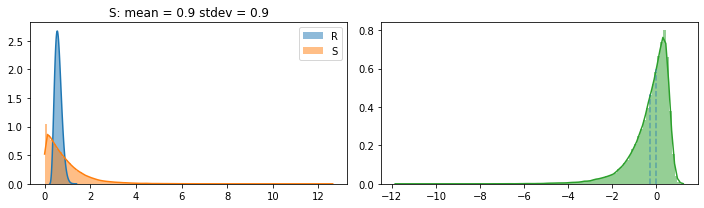

In [9]:
# initialize model
model_cl = Chloride_Model(pars_raw)

# run for 40 mm and 10 year
model_cl.run(x = 40, t = 10)

# postproc
model_cl.postproc(plot=True)

In [10]:
# Calibration
# field data at three depth
chloride_content_field = pd.DataFrame()
chloride_content_field['depth'] = [12.5, 50, 100]  # [mm]
chloride_content_field['cl'] = np.array([0.226, 0.04, 0.014]) / pars_raw.cement_concrete_ratio  # chloride_content[wt.-%/cement]
print(chloride_content_field)

NameError: name 'np' is not defined

In [5]:
#calibrate model to the field chloride content
model_cl_cal = model_cl.calibrate(40, chloride_content_field,print_proc=False, plot=True) 

AttributeError: 'DataFrame' object has no attribute 'cl'

In [6]:
# run the calibrated model for 40 mm and 10 year
model_cl_cal.run(x = 40, t = 10)
model_cl_cal.postproc(plot=True)
# plt.savefig('chloride_at_rebar_40year.pdf',dpi=1200)

NameError: name 'model_cl_cal' is not defined

/Users/gangli/Local Documents/Mitacs project local/Tinkrete/modules/chloride.py:66: RuntimeWarning: invalid value encountered in sqrt
  1 - erf((x - pars.dx) / (2 * (pars.D_app * t) ** 0.5))
/Users/gangli/Local Documents/Mitacs project local/Tinkrete/modules/helper_func.py:440: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  lambda x: R_distrib.cdf(x) * S_kde_fit(x)[0], 0, S_dropna.max()


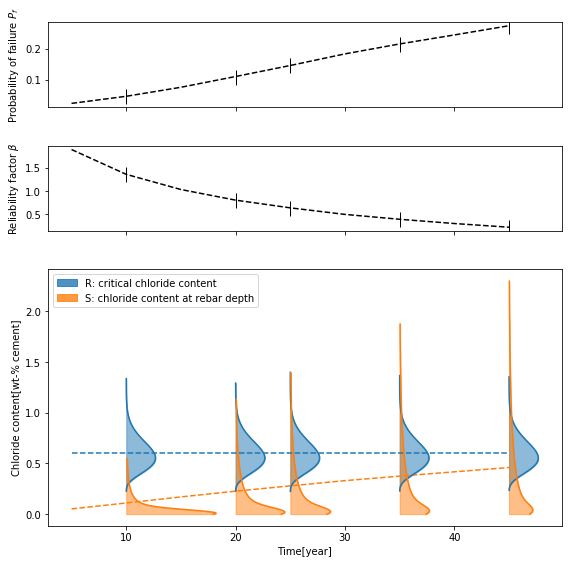

In [19]:
# run model for a list of time steps
t_lis = np.arange(5,50,5)
cover = 50
pf_lis, beta_lis = model_cl_cal.chloride_with_year(depth=cover, year_lis=t_lis,amplify=1)
# fig.savefig('RS_time_chloride.pdf',dpi=1200)
